In [1]:
from pathlib import Path
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import torch
import SimpleITK as sitk
from tqdm.notebook import tqdm

In [2]:
def eceloss(softmaxes, labels, n_bins=15):
    """
    Modified from https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    """
    d = softmaxes.device
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=d)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    
    accuracy_in_bin_list = []
    avg_confidence_in_bin_list = []

    ece = torch.zeros(1, device=d)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        # if prop_in_bin.item() > 0.0:
        accuracy_in_bin = accuracies[in_bin].float().mean()
        avg_confidence_in_bin = confidences[in_bin].mean()
        if prop_in_bin.item() > 0.0:
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        accuracy_in_bin_list.append(accuracy_in_bin)
        avg_confidence_in_bin_list.append(avg_confidence_in_bin)

    acc_in_bin = torch.tensor(accuracy_in_bin_list, device=d)
    avg_conf_in_bin = torch.tensor(avg_confidence_in_bin_list, device=d)

    return ece, acc_in_bin, avg_conf_in_bin

def plot_conf(conf, mean_acc, std_acc=None, title=None, ax=None,label=None):
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(1, 1) # , figsize=(2.5, 2.25))
        return_fig = True
    ax.plot([0,1], [0,1], 'k--')
    # ax.plot(conf.data.cpu().numpy(), acc.data.cpu().numpy(), marker='.')
    ax.plot(conf, mean_acc, marker='.',label=label)
    if std_acc is not None:
        ax.fill_between(conf, mean_acc-std_acc, mean_acc+std_acc, alpha=.3)
    ax.set_xlabel(r'confidence')
    ax.set_ylabel(r'accuracy')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))
    # textstr = r'ECE$\,=\,{:.2f}$'.format(ece*100)
    # props = dict(boxstyle='round', facecolor='white', alpha=0.75)
    # ax.text(0.075, 0.925, textstr, transform=ax.transAxes, fontsize=14,
    #         verticalalignment='top',
    #         horizontalalignment='left',
    #         bbox=props
    #         )
    if title is not None:
        ax.set_title(fr'{title}')
    ax.set_aspect(1.)
    if return_fig:
        fig.tight_layout()
        return fig

In [3]:
from train import LABEL_SUBSETS
dataset_names = list(LABEL_SUBSETS.keys())
dataset_names

['Dataset001_visceral_gc',
 'Dataset002_visceral_sc',
 'Dataset004_lits',
 'Dataset005_bcv_abdomen',
 'Dataset006_bcv_cervix',
 'Dataset007_chaos',
 'Dataset009_abdomenct1k',
 'Dataset014_learn2reg',
 'Dataset037_totalsegmentator',
 'Dataset038_amos']

In [4]:
train_labels = [LABEL_SUBSETS[ds_name] for ds_name in dataset_names]
train_labels = np.unique([xx for x in train_labels for xx in x])
train_labels = {l: i+1 for i, l in enumerate(train_labels)}
train_labels_t = {i: l for l, i in train_labels.items()}
train_labels_t

{1: np.str_('aorta'),
 2: np.str_('duodenum'),
 3: np.str_('esophagous'),
 4: np.str_('gall bladder'),
 5: np.str_('left kidney'),
 6: np.str_('liver'),
 7: np.str_('pancreas'),
 8: np.str_('right kidney'),
 9: np.str_('spleen'),
 10: np.str_('stomach'),
 11: np.str_('trachea'),
 12: np.str_('urinary bladder')}

In [5]:
def normalize(x):
    # p05 = np.percentile(x, 0.05)
    p95 = np.percentile(x, 99)
    x = np.clip(x, 0, p95)
    x = (x-x.min())/(x.max()-x.min())
    return x

In [6]:
exp_path = Path('/mnt/sds/sd20i001/malte/code/FedUWAvg/federated_subset')

eces_van_fed, eces_fun_fed = {i: [] for i in range(1,13)}, {i: [] for i in range(1,13)}

eces_van_fed_all, eces_fun_fed_all = [], []
for ds_name in tqdm(dataset_names):
    for logits_fun_path in exp_path.glob(f'{ds_name}_*_merged_logits_fun.pt'):
        case = logits_fun_path.name.replace(f'{ds_name}_','').replace('_merged_logits_fun.pt', '')
        logits_path = logits_fun_path.parent / logits_fun_path.name.replace('_fun.pt', '.pt')
        target_path = logits_fun_path.parent / logits_fun_path.name.replace('_merged_logits_fun.pt', '_targets.nii.gz')
        logits = torch.from_numpy(torch.load(logits_path))
        logits_fun = torch.from_numpy(torch.load(logits_fun_path))
        target = sitk.ReadImage(target_path)
        target = torch.from_numpy(sitk.GetArrayFromImage(target))

        eces_van_fed_all.append(eceloss(normalize(logits), target))
        eces_fun_fed_all.append(eceloss(normalize(logits_fun), target))

        for i in torch.unique(target)[1:]:
            i_logits = torch.stack([logits[0,j][target==i] for j in range(logits.size(1))])
            eces_van_fed[i.item()].append(eceloss(i_logits[None], target[target==i], n_bins=15))

            i_logits_fun = torch.stack([logits_fun[0,j][target==i] for j in range(logits.size(1))])
            eces_fun_fed[i.item()].append(eceloss(i_logits_fun[None], target[target==i], n_bins=15))

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
exp_path = Path('/mnt/sds/sd20i001/malte/code/FedUWAvg/central_subset')

eces_van_central, eces_fun_central = {i: [] for i in range(1,13)}, {i: [] for i in range(1,13)} # [], []
eces_van_cen_all, eces_fun_cen_all = [], []
for ds_name in tqdm(dataset_names):
# ds_name = 'Dataset037_totalsegmentator'
    for logits_fun_path in exp_path.glob(f'{ds_name}_*_merged_logits_fun.pt'):
        case = logits_fun_path.name.replace(f'{ds_name}_','').replace('_merged_logits_fun.pt', '')
        logits_path = logits_fun_path.parent / logits_fun_path.name.replace('_fun.pt', '.pt')
        target_path = logits_fun_path.parent / logits_fun_path.name.replace('_merged_logits_fun.pt', '_targets.nii.gz')
        logits = torch.from_numpy(torch.load(logits_path))
        logits_fun = torch.from_numpy(torch.load(logits_fun_path))
        target = sitk.ReadImage(target_path)
        target = torch.from_numpy(sitk.GetArrayFromImage(target))
        
        eces_van_cen_all.append(eceloss(normalize(logits), target))
        eces_fun_cen_all.append(eceloss(normalize(logits_fun), target))

        for i in torch.unique(target)[1:]:
            i_logits = torch.stack([logits[0,j][target==i] for j in range(logits.size(1))])
            eces_van_central[i.item()].append(eceloss(i_logits[None], target[target==i], n_bins=15))

            i_logits_fun = torch.stack([logits_fun[0,j][target==i] for j in range(logits.size(1))])
            eces_fun_central[i.item()].append(eceloss(i_logits_fun[None], target[target==i], n_bins=15))

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
acc_van_cen = np.array([x[1] for x in eces_van_cen_all])
conf_van_cen = np.array([x[2] for x in eces_van_cen_all])
acc_fun_cen = np.array([x[1] for x in eces_fun_cen_all])
conf_fun_cen = np.array([x[2] for x in eces_fun_cen_all])
acc_van_fed = np.array([x[1] for x in eces_van_fed_all])
conf_van_fed = np.array([x[2] for x in eces_van_fed_all])
acc_fun_fed = np.array([x[1] for x in eces_fun_fed_all])
conf_fun_fed = np.array([x[2] for x in eces_fun_fed_all])

In [9]:
# torch.save(eces_van_central, 'eces/eces_van_central.pt')
# torch.save(eces_fun_central, 'eces/eces_fun_central.pt')
# torch.save(eces_van_fed, 'eces/eces_van_fed.pt')
# torch.save(eces_fun_fed, 'eces/eces_fun_fed.pt')

In [10]:
eces_van_central = torch.load('eces/eces_van_central.pt')
eces_fun_central = torch.load('eces/eces_fun_central.pt')
eces_van_fed = torch.load('eces/eces_van_fed.pt')
eces_fun_fed = torch.load('eces/eces_fun_fed.pt')

In [11]:
eces = {'van_central': [], 'fun_central': [], 'van_fed': [], 'fun_fed': []}
for i in range(1,13):
    eces['van_central'].append(np.nanmean([x[0].item() for x in eces_van_central[i]]))
    eces['fun_central'].append(np.nanmean([x[0].item() for x in eces_fun_central[i]]))
    eces['van_fed'].append(np.nanmean([x[0].item() for x in eces_van_fed[i]]))
    eces['fun_fed'].append(np.nanmean([x[0].item() for x in eces_fun_fed[i]]))
esces = {}
for m, e in eces.items():
    esces[m] = rf'{np.nanmean(e)*100:.2f} $\pm$ {np.nanstd(e)*100:.2f}'

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


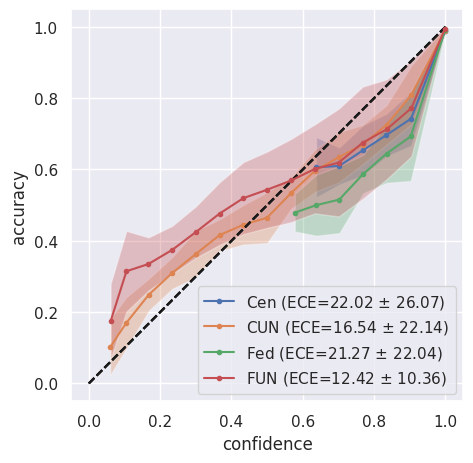

In [13]:
fig,ax = plt.subplots()
plot_conf(conf_van_cen.mean(0), acc_van_cen.mean(0), acc_van_cen.std(0), ax=ax, label=rf'Cen (ECE={esces["van_central"]})')
plot_conf(conf_fun_cen.mean(0), acc_fun_cen.mean(0), acc_fun_cen.std(0), ax=ax, label=rf'CUN (ECE={esces["fun_central"]})')
plot_conf(conf_van_fed.mean(0), acc_van_fed.mean(0), acc_van_fed.std(0), ax=ax, label=rf'Fed (ECE={esces["van_fed"]})')
plot_conf(conf_fun_fed.mean(0), acc_fun_fed.mean(0), acc_fun_fed.std(0), ax=ax, label=rf'FUN (ECE={esces["fun_fed"]})')
ax.legend()
fig.tight_layout()
fig.savefig('calibration_rebuttal.pdf', bbox_inches='tight')